In [1]:
import numpy as np
import math

from numpy import exp
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
from scipy.integrate import cumtrapz, quad
from scipy.special import erf

from WIMpy import DMUtils as DMU

from matplotlib import pyplot as plt
from matplotlib.ticker import LogLocator

import matplotlib as mpl
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=16)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

import paleopy as paleopy

import os.path

In [2]:
R = []
E = []
R_o = []
E_o = []
nuclei_o = ('Si', 'Al', 'Fe', 'Ca', 'Na', 'K', 'O')
nuclei = ('Zr', 'Si', 'O')
fractions_o = [0.249, 0.054, 0.005, 0.003, 0.023, 0.035, 0.631]
fractions = [0.1667, 0.1667, 0.6667]

rho_o = 2.55 #g cm^-3
rho = 4.7

for i in range(len(nuclei)):
    dirname = './Range/'+nuclei[i]+'.txt'
    e, r = np.loadtxt(dirname, usecols = (0, 2), unpack = 'true')
    unit = np.loadtxt(dirname, usecols = (1), dtype = str, unpack = 'true')
    for k in range(len(unit)):
        if (unit[i] == 'GeV'): e[i] = e[i]*1000
    E.append(e)
    R.append(r)
    
for i in range(len(nuclei_o)):
    dirname = './Range/'+nuclei_o[i]+'.txt'
    e, r = np.loadtxt(dirname, usecols = (0, 2), unpack = 'true')
    unit = np.loadtxt(dirname, usecols = (1), dtype = str, unpack = 'true')
    for k in range(len(unit)):
        if (unit[i] == 'GeV'): e[i] = e[i]*1000
    E_o.append(e)
    R_o.append(r)

In [3]:
print(R[0], R[1])

[  1.172   2.098   3.858   7.598  12.12   35.05   48.21   76.17  119.9
 194.    267.4   550.   ] [8.904e-01 1.608e+00 2.981e+00 5.918e+00 9.488e+00 2.771e+01 3.824e+01
 6.065e+01 9.591e+01 1.559e+02 2.157e+02 4.475e+02 5.595e+02 7.776e+02
 1.094e+03 1.604e+03 2.099e+03 3.994e+03]


In [4]:
Rtot = np.zeros(len(R[0]))
for i in range(len(R[0])):
    for k in range(len(nuclei)):
        Rtot[i] += R[k][i]*fractions[k]
        
Rtot_o = np.zeros(len(R_o[0]))
for i in range(len(R_o[0])):
    for k in range(len(nuclei_o)):
        Rtot_o[i] += R_o[k][i]*fractions_o[k]

In [5]:
print(Rtot)

[  0.88276236   1.5951724    2.9601523    5.8799652    9.4296783
  27.542946    37.992394    60.249766    95.211822   154.53314
 213.40608    440.03027   ]


In [6]:
Rtot = Rtot/rho
Rtot_o = Rtot_o/rho_o
Energy = E[0]
Energy_o = E_o[0]

In [7]:
print(Energy, Rtot)

[ 10.  14.  20.  30.  40.  80. 100. 140. 200. 300. 400. 800.] [ 0.18782178  0.33939838  0.62981964  1.25105643  2.00631453  5.86020128
  8.08348809 12.81909915 20.25783447 32.87939149 45.40554894 93.6234617 ]


In [8]:
import scipy as sp
import scipy.interpolate

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value='extrapolate')
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

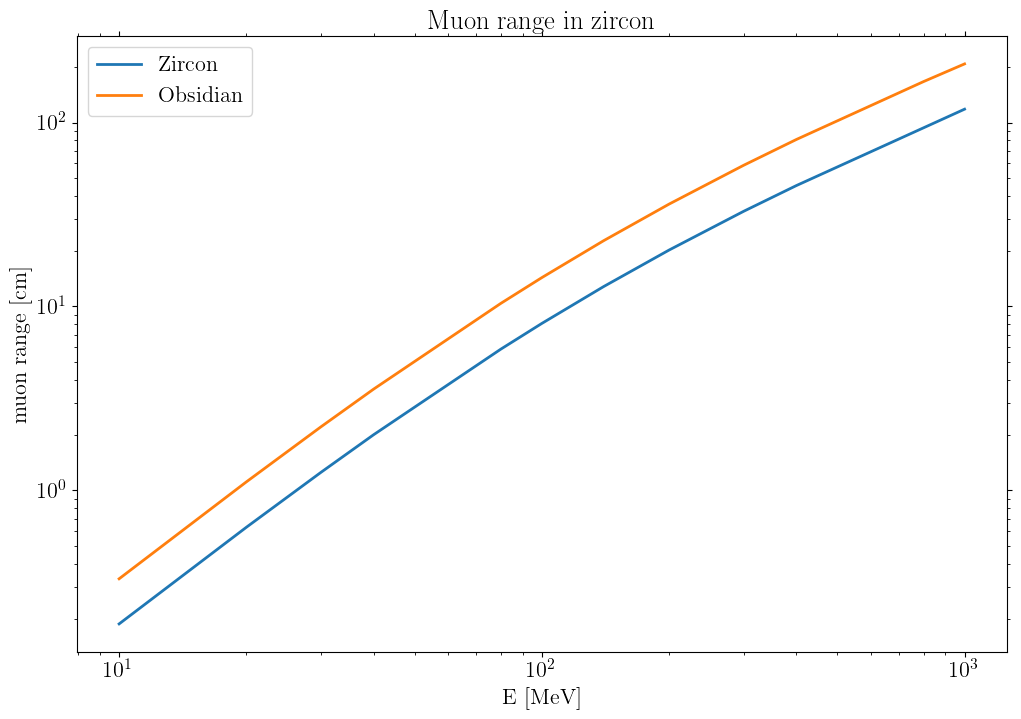

In [9]:
func = log_interp1d(Energy, Rtot)
func_o = log_interp1d(Energy_o, Rtot_o)
En = np.linspace(10, 1000, 100)

plt.figure(figsize=(12,8))

plt.loglog(En, func(En), label = 'Zircon', linewidth=2)
plt.loglog(En, func_o(En), label = 'Obsidian', linewidth=2)

plt.legend()
plt.title(r"Muon range in zircon")
plt.xlabel(r"E [MeV]")
plt.ylabel(r" muon range [cm]")
plt.show()

# Induced fission

In [10]:
fission = 0.14

In [11]:
def energySFF(A0,Z0,B0,A1,Z1,B1,A2,Z2,B2):

    mp = 938.3 #MeV
    mn = 939.6 #MeV

    M  = Z0*mp + (A0-Z0)*mn - B0*A0
    m1 = Z1*mp + (A1-Z1)*mn - B1*A1
    m2 = Z2*mp + (A2-Z2)*mn - B2*A2

    Ek1 = (M**2 + m1**2 - m2**2)/(2*M) - m1
    Ek2 = (M**2 + m2**2 - m1**2)/(2*M) - m2
    
    return Ek1,Ek2

In [12]:
Z0,A0,E0 = np.loadtxt("U238.dat", usecols = (1,2,3), unpack='true')

In [13]:
Z_list,A_list,B_list = np.loadtxt("BindingEne.txt", usecols = (0,1,2), unpack='true')

Z = []
A = []
E = []
Z_list0 = []
A_list0 = []

N0 = len(Z0)

for i in range (int(N0/3)):
    z1 = Z0[3*i + 1]
    a1 = A0[3*i + 1]
    z2 = Z0[3*i + 2]
    a2 = A0[3*i + 2]

    if(z1 not in Z):
        Z_list0.append(z1)
        A_list0.append(a1)
            
    if(z2 not in Z):            
        Z_list0.append(z2)
        A_list0.append(a2)
            
    Z.append(Z0[3*i + 1])
    A.append(A0[3*i + 1])
        
    Z.append(Z0[3*i + 2])
    A.append(A0[3*i + 2])
    
    b1 = 0
    b2 = 0
    
    for j in range(len(Z_list)):
        if(z1 == Z_list[j] and a1 == A_list[j]):
            b1 = B_list[j]            
        if(z2 == Z_list[j] and a2 == A_list[j]):
            b2 = B_list[j]
            
    e1,e2 = energySFF(238,92,7.570126,a1,z1,b1,a2,z2,b2)
        
    E.append(e1) # MeV
    E.append(e2)

#print(Z_list0)
#print(A_list0)
        
N = len(Z)
M = len(Z_list)

#Z[] contains all the possible Z which comes from 238U fission organized as: Z1,Z2,Z1,Z2...(Z1<Z2). A contains their
#A, E[] contains their kinetik energy

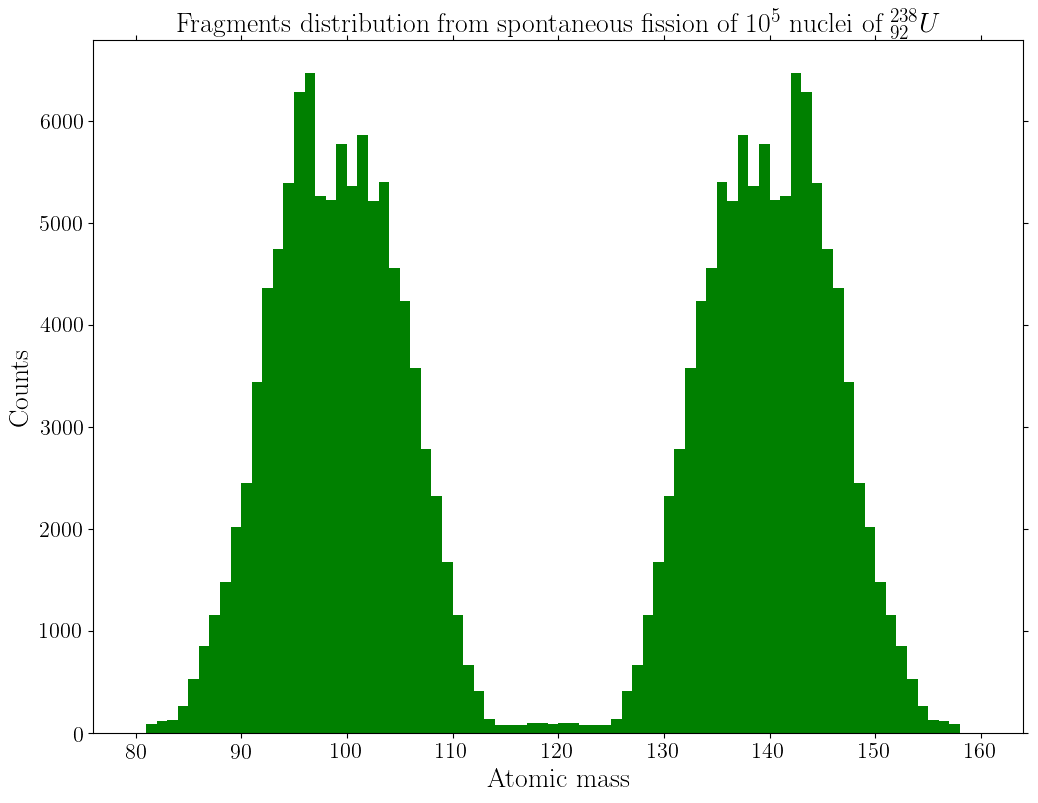

In [14]:
fig = plt.subplots(figsize =(12, 9))
plt.hist(A, 80, range = (80,160),color='g')
#plt.hist(Z, 29, range = (29,92-29),color='g')
#plt.hist(np.log10(E),80,log=True)
plt.title(r"Fragments distribution from spontaneous fission of $10^5$ nuclei of $^{238}_{92}U$", fontsize = 20)
plt.xlabel("Atomic mass", fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.savefig("FissionFrag.jpg",bbox_inches="tight")
plt.show()

In [15]:
track = []
#strag = []

#print(N)

#mineral = 'Gypsum/'
#nuclei  = ' H- O-Ca- S'

#mineral = 'Halite/'
#nuclei = 'Na-Cl.txt'

mineral = 'Obsidian/'
nuclei = 'Si-Al-Fe-Ca-Na- K- O.txt'

mineral = 'Zircon/'
nuclei = 'Zr-Si- O.txt'

#mineral = 'Cerussite/'
#nuclei = ' O-Pb- C.txt'

#mineral = 'Pyromorphite/'
#nuclei = 'Pb- P- O-Cl.txt'

appo = 0

for i in range(N):
    
    if(i%10000 == 0):
        print(i)
    
    #e takes the energy of the fragment, x and y take the range obtained in the material
    
    e,x,y  = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = (0,4,8), unpack='true')
    unit_e = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 1, dtype = str, unpack='true')
    unit_x = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 5, dtype = str, unpack='true')
    #unit_y = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 9, dtype = str, unpack='true')
    
    n = len(unit_e)
    
    for j in range(n):    
        if(unit_x[j] == "um"):
            x[j] *= 1e3
        else:
            x[j] *= 0.1
       
        '''if(unit_y[i] == "um"):
            y[i] *= 1e3
        else:
            y[i] *= 0.1'''
            
        if(unit_e[j] == "eV"):
            e[j] *= 1e-3
        elif(unit_e[j] == "MeV"):
            e[j] *= 1e3
            
    Etox = InterpolatedUnivariateSpline(e,x,k = 1)
    #Etoy = InterpolatedUnivariateSpline(e,y,k = 1)
    
    if (i % 2 == 0):   
        appo = Etox(E[i]*1e3)
        #length by the lighter fragment
    else:
        appo += Etox(E[i]*1e3)        
        track.append(appo)
        #sum of the length by the 2 objects
        
    #track.append(Etox(E[i]*1e3))
    #strag.append(Etoy(E[i]*1e3))
    
#print(min(track))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [16]:
n_bins = 200
x_min = -1 #log scale in nm
x_max = 5 #log scale in nm

#I consder the range between 1 nm and 10^5 nm

In [17]:
lenght = np.logspace(x_min,x_max,n_bins) # nm
count  = np.zeros(n_bins-1)

for i in range(int(N/2)):
    if(i%10000 == 0):
        print(i)
    for j in range(n_bins-1):
        if(track[i] >= lenght[j] and track[i] < lenght[j+1]):
            count[j] += 1
            #counting the decays which gave a track with length between length[j] and length[j+1]

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [18]:
l = np.logspace(x_min,x_max,10000)
R = np.zeros(10000)

for i in range(n_bins-1):
    for j in range(10000):
        if(l[j] < lenght[i+1] and l[j] >= lenght[i]):
            R[j] = count[i]

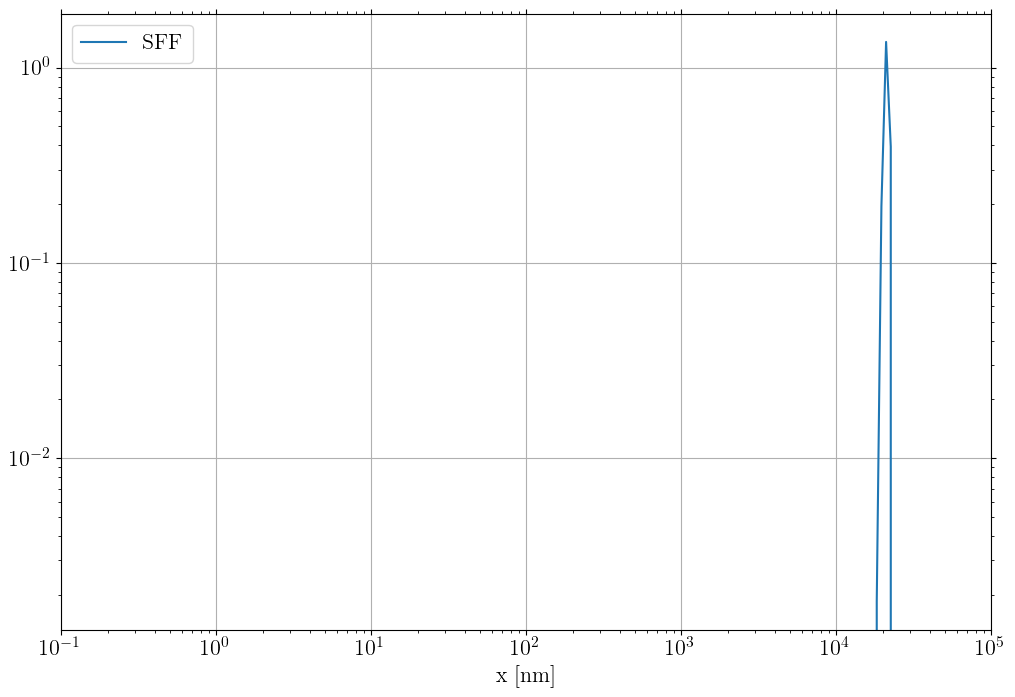

In [19]:
Na  = 6.022e23
tau = 6.45e3 #Myr 
t   = 1.0     #Myr
# mass = 1 g
#       weight   BR     U-frac    unit mass   decay law

factor = 1e-5*(5.4e-7)*((1e-10)*Na*1e3/(238))/tau

#BR = 5.4e-7
#f = 1e-5 #to get distribution
#U = Na/238*1e3 #number of atoms in a 1 kg of Uranium
#decays = (1/tau) #number of decays in per Myr
#Ufrac = 0.1*1e-9 # f=0.1 ppb

#factor = f*U*decays*Ufrac

#print(factor)

lenght_width = np.diff(lenght)
lenght_mid   = lenght[:-1] + lenght_width/2

plt.figure(figsize=(12,8))
#plt.loglog(l,R*factor, label='SFF')
plt.loglog(lenght_mid,count*factor/lenght_width, label='SFF')
ax = plt.gca()
#plt.title("Recoils spectra in Obsidian from spontaneous fission of ^{238}_{92}U")
#plt.ylabel("dR/dE [recoils/Myr/keV/cmq]")
#plt.ylabel("dR/dx [Myr^-1 nm^-1 kg^-1]")
plt.xlabel("x [nm]")
plt.grid()
plt.legend()
plt.xlim(0.1,1e5)
#plt.savefig("Muon_nucRecoil.jpg",bbox_inches="tight")
plt.show()

In [20]:
fission = 0.14
flux = 0.0033065861700891284/((1.1590510483144822**2)*1e3) #cm^-2 s^-1 sr^-1 MeV^-1
print(flux)

2.4613576096485813e-06


2438547369938.0933


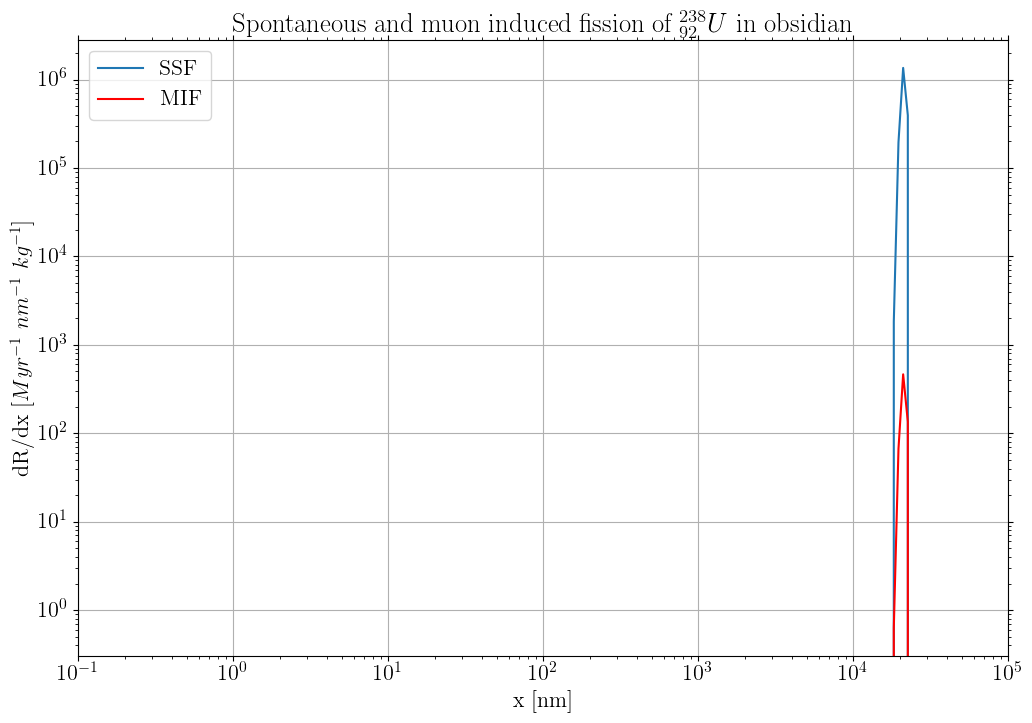

0.0003428437228473395


In [21]:
Number = flux*100*np.pi*100*3600*24*365*1e6 #*cm^2*sr*MeV*Myr = muoni che incidono in un Myr
fraction = 1e-4
print(Number)

mass = 10**3*rho*1e-3
factor1 = 1e-5*(5.4e-7)*((fraction)*Na*1e3/(238))/tau
factor2 = 1e-5*(0.14*Number)*(fraction)/mass*(np.exp(-1/tau))
#1e-5 perchè conto il numero di tracce per fissione, 0.14*Number il numero di fissioni se fosse tutto U, 1e-4 perchè è la frazione di U

lenght_width = np.diff(lenght)
lenght_mid   = lenght[:-1] + lenght_width/2

plt.figure(figsize=(12,8))
#plt.loglog(l,R*factor, label='SFF')
plt.loglog(lenght_mid,count*factor1/lenght_width, label='SSF')
plt.loglog(lenght_mid,count*factor2/lenght_width, label='MIF', color = 'red')
ax = plt.gca()
plt.title(r"Spontaneous and muon induced fission of $^{238}_{92}U$ in obsidian")
plt.ylabel("dR/dE [recoils/Myr/keV/cmq]")
plt.ylabel("dR/dx [$Myr^{-1} \ nm^{-1} \ kg^{-1}$]")
plt.xlabel("x [nm]")
plt.grid()
plt.legend()
plt.xlim(0.1,1e5)
plt.savefig("MuonFission.pdf",bbox_inches="tight")
plt.show()

print(factor2/factor1)

In [22]:
from scipy.optimize import curve_fit

In [23]:
for i in range(len(nuclei)):
    dirname = '../Resconi.txt'
    e, flux = np.loadtxt(dirname, usecols = (0, 1), delimiter = ', ', unpack = 'true')
n = 20
E = np.zeros(n)
F = np.zeros(n)
for i in range(n):
    E[i] = e[i]*1e3 #MeV
    F[i] = flux[i]/((e[i]**3)*1e3) #cm^-2 sr^-1 s^-1 MeV^-1

In [24]:
def func(x, a, b, c, d, e):
    return a + b * x + c * x**2 + d * x**3 + e * x**4

In [25]:
popt, pcov = curve_fit(func, E, F)
#funct = log_interp1d(e, flux)

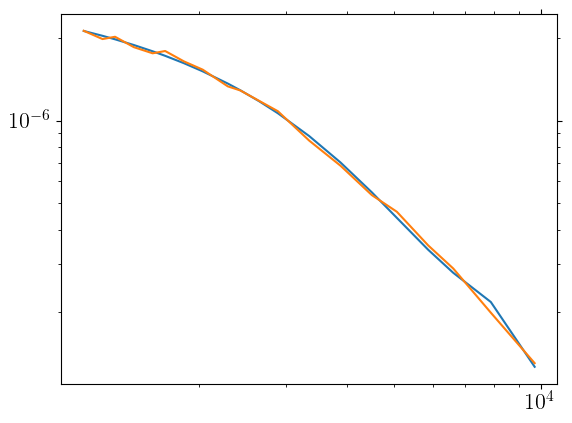

In [26]:
plt.loglog(E, func(E, *popt))
plt.loglog(E, F)
#plt.loglog(e, funct(e), label='Esperimenti', linewidth=2)

10.0 3.215397963790618e-06
21.25 3.2028699322421566e-06
32.5 3.1903799907564894e-06
43.75 3.1779280688518126e-06
55.0 3.1655140960933146e-06
66.25 3.1531380020931723e-06
77.5 3.140799716510554e-06
88.75 3.12849916905162e-06
100.0 3.1162362894695194e-06


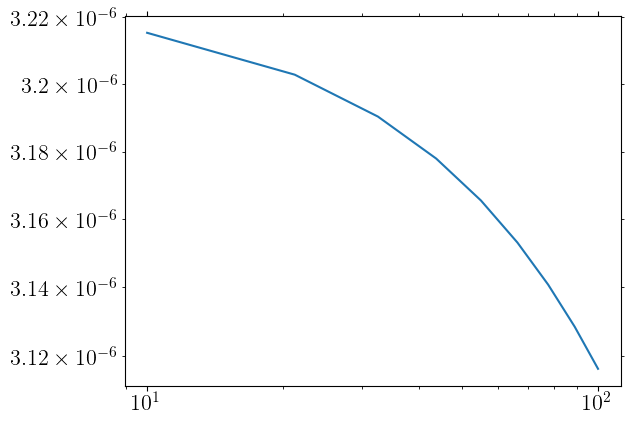

In [27]:
En = np.linspace(10, 100, 9)
for i in range(9):
    print(En[i], func(En[i], *popt))
plt.loglog(En, func(En, *popt))

In [28]:
Ezr = 500
f = lambda x : func(x, *popt)
Number = quad(f, 0, Ezr)[0]*np.pi*100*3600*24*365*1e6
print(Number)

14659446509074.63


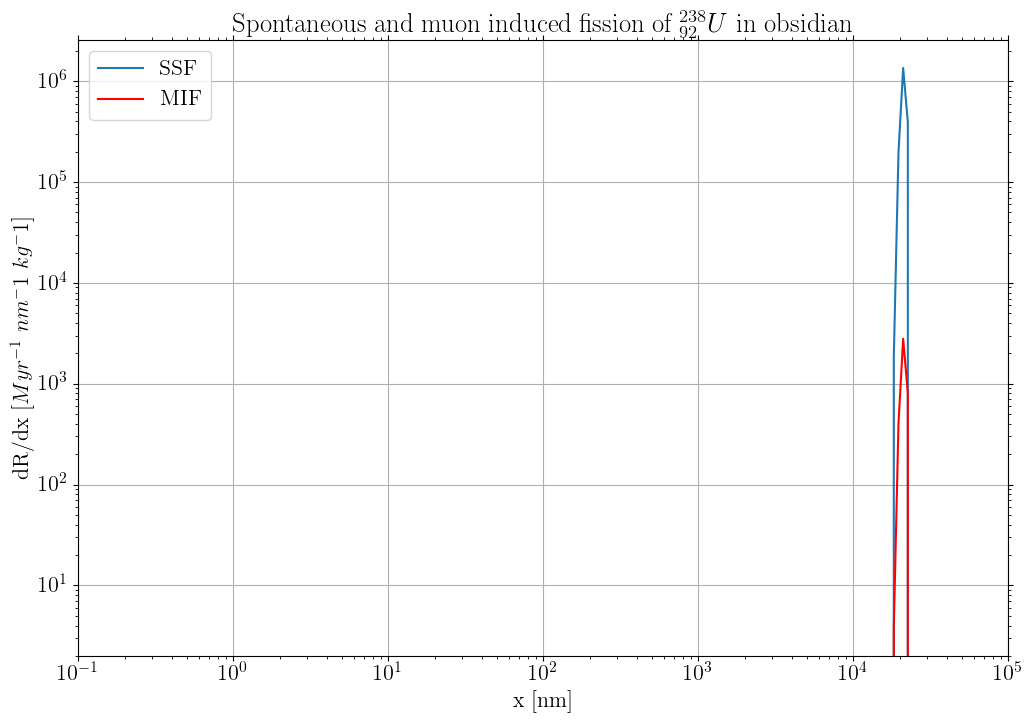

0.002061021769767865


In [29]:
mass = 10**3*rho*1e-3
factor1 = 1e-5*(5.4e-7)*((fraction)*Na*1e3/(238))/tau
factor2 = 1e-5*(0.14*Number)*(fraction)/mass*(np.exp(-1/tau))
#1e-5 perchè conto il numero di tracce per fissione, 0.14*Number il numero di fissioni se fosse tutto U, 1e-10 perchè è la frazione di U

lenght_width = np.diff(lenght)
lenght_mid   = lenght[:-1] + lenght_width/2

plt.figure(figsize=(12,8))
#plt.loglog(l,R*factor, label='SFF')
plt.loglog(lenght_mid,count*factor1/lenght_width, label='SSF')
plt.loglog(lenght_mid,count*factor2/lenght_width, label='MIF', color = 'red')
ax = plt.gca()
plt.title(r"Spontaneous and muon induced fission of $^{238}_{92}U$ in obsidian")
plt.ylabel("dR/dE [recoils/Myr/keV/cmq]")
plt.ylabel("dR/dx [$Myr^{-1} \ nm{^-1} \ kg{^-1}$]")
plt.xlabel("x [nm]")
plt.grid()
plt.legend()
plt.xlim(0.1,1e5)
plt.savefig("MuonFission.pdf",bbox_inches="tight")
plt.show()

print(factor2/factor1)

In [30]:
N = 0
for i in range(len(count)):
    N += count[i]*factor1
print(N)

2855324768.418996


In [31]:
print(N*3900*1e-6*1e-3*rho*1000) # cm^-3 

52338103.005120195


In [106]:
def Asimm(A):
    A0 = 232
    A1 = 134
    A2 = 142
    sigma2 = 5.6
    sigma1 = sigma2/2
    cas = 0.5
    return np.exp(-(A-A2)**2/(2*sigma2**2))+np.exp(-(A-(A0-A2))**2/(2*sigma2**2))+cas*np.exp(-(A-A1)**2/(2*sigma1**2))+np.exp(-(A-(A0-A1))**2/(2*sigma1**2))

[ 68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.
 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123.
 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137.
 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151.
 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165.]


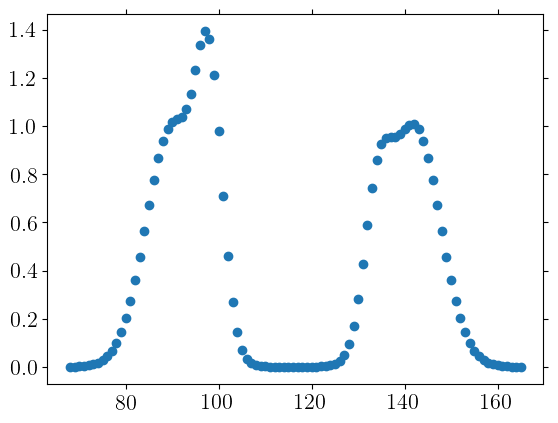

In [107]:
Arange = np.linspace(68, 165, 98)
print(Arange)
plt.scatter(Arange, Asimm(Arange))

In [108]:
Prob = []
Tot = 0
Prob.append(Asimm(68))
Tot = Asimm(68)
for i in range(97):
    Prob.append(Prob[i]+Asimm(Arange[i+1]))
    Tot += Asimm(Arange[i+1])
print(Tot)

38.60148676004133


In [109]:
Prob = Prob/Tot
print(Prob*100000)

[1.15349670e+00 3.44311397e+00 7.84522256e+00 1.60432607e+01
 3.08312948e+01 5.66694959e+01 1.00398081e+02 1.72081698e+02
 2.85903567e+02 4.60961920e+02 7.21752134e+02 1.09806673e+03
 1.62403818e+03 2.33611131e+03 3.26987812e+03 4.45593075e+03
 5.91515712e+03 7.65416283e+03 9.66170243e+03 1.19071353e+04
 1.43420542e+04 1.69064397e+04 1.95407421e+04 2.22041615e+04
 2.48954685e+04 2.76657193e+04 3.06067595e+04 3.38049279e+04
 3.72714181e+04 4.08879860e+04 4.44123264e+04 4.75549162e+04
 5.00881612e+04 5.19236925e+04 5.31182493e+04 5.38192791e+04
 5.41938912e+04 5.43793967e+04 5.44668539e+04 5.45074801e+04
 5.45266703e+04 5.45360219e+04 5.45406903e+04 5.45430345e+04
 5.45441991e+04 5.45447674e+04 5.45450434e+04 5.45451884e+04
 5.45452964e+04 5.45454415e+04 5.45457173e+04 5.45462848e+04
 5.45474447e+04 5.45497619e+04 5.45542972e+04 5.45630721e+04
 5.45800612e+04 5.46132934e+04 5.46788863e+04 5.48074808e+04
 5.50516978e+04 5.54897419e+04 5.62174154e+04 5.73233384e+04
 5.88529466e+04 6.078027

In [110]:
import random as ran

def Extr(n):
    s = np.zeros(n)
    B = Prob*n
    Arange = np.linspace(68, 165, 98)
    for i in range(n):
        a = ran.random()*n
        for j in range(len(B)):
            if (a<B[j]): 
                s[i] = Arange[j]
                break
    return(s)

In [111]:
A = Extr(100000)

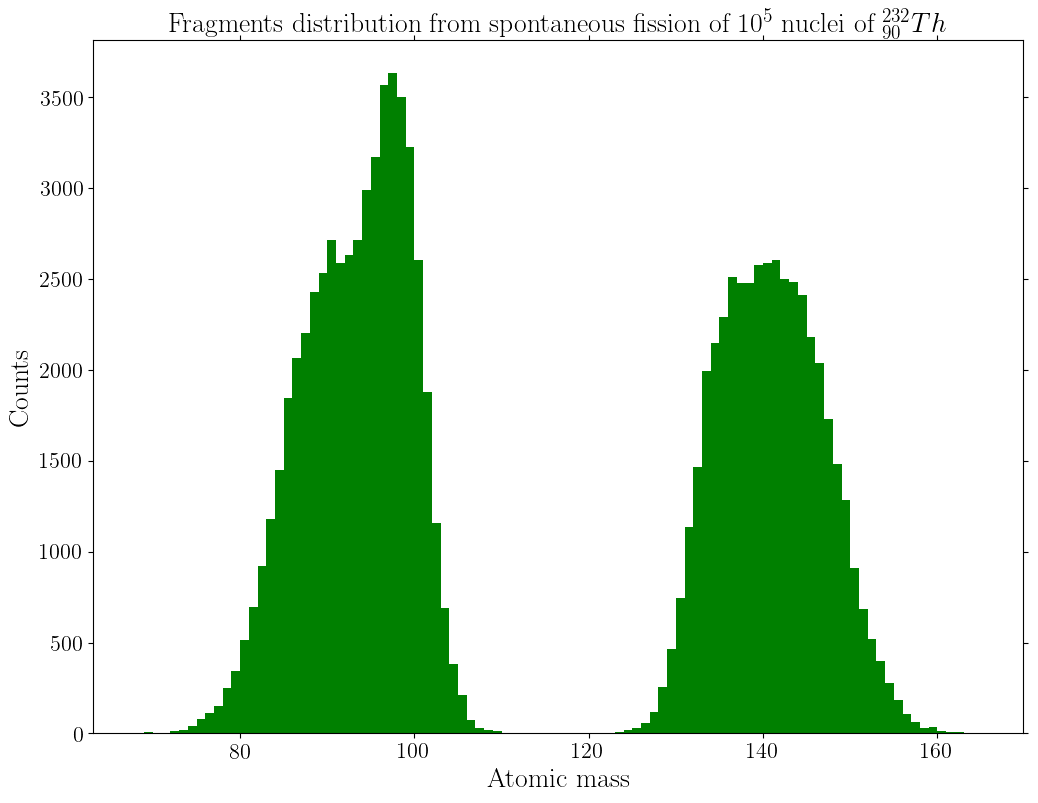

In [112]:
fig = plt.subplots(figsize =(12, 9))
plt.hist(A, 97, range = (68,165),color='g')
#plt.hist(Z, 29, range = (29,92-29),color='g')
#plt.hist(np.log10(E),80,log=True)
plt.title(r"Fragments distribution from spontaneous fission of $10^5$ nuclei of $^{232}_{90}Th$", fontsize = 20)
plt.xlabel("Atomic mass", fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.savefig("FissionFrag.jpg",bbox_inches="tight")
plt.show()

In [113]:
print(A)

[134. 138.  89. ...  95. 100.  95.]


In [114]:
'''
filename = 'A232ThOrdered.txt'
f = open(filename, "w")
print("#Atomic mass", file=f)
Asort = A.sort()
Awrite = []
for j in range (len(A)) :
    if (A[j] not in Awrite):
        Awrite.append(A[j])
        print(A[j], file = f)
f.close()
'''

'\nfilename = \'A232ThOrdered.txt\'\nf = open(filename, "w")\nprint("#Atomic mass", file=f)\nAsort = A.sort()\nAwrite = []\nfor j in range (len(A)) :\n    if (A[j] not in Awrite):\n        Awrite.append(A[j])\n        print(A[j], file = f)\nf.close()\n'

In [115]:
A0,Z0,E0 = np.loadtxt("232Th.txt", usecols = (0,1,2), unpack='true')

In [116]:
a1 = []
a2 = []
z1 = []
z2 = []
e1 = []
e2 = []
for i in range(len(A0)):
    if(i%2 == 0):
        a1.append(A0[i])
        z1.append(Z0[i])
        e1.append(E0[i])
    if(i%2 == 1):
        a2.append(A0[i])
        z2.append(Z0[i])
        e2.append(E0[i])

In [117]:
filename = 'Th232.dat'
f = open(filename, "w")
print("#  Z  A", file=f)
for j in range(len(A)):
    print(j+1, 90, 232, sep = '  ', file = f)
    for i in range(len(a1)):
        if(A[j]==a1[i]):
            print(j+1, z1[i], a1[i], sep = '  ', file = f)
            print(j+1, z2[i], a2[i], sep = '  ', file = f)
            break
    for i in range(len(a2)):
        if(A[j]==a2[i]):
            print(j+1, z1[i], a1[i], sep = '  ', file = f)
            print(j+1, z2[i], a2[i], sep = '  ', file = f)
            break
    if(A[j] not in a1):
        if(A[j] not in a2):
            print(A[j])
    

In [118]:
f.close()